<a href="https://colab.research.google.com/github/ziatdinovmax/ChemDisc/blob/main/ChemDisc_notebook1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Machine learning discovery of chemical transformation pathways from atomically-resolved imaging data - Notebook I

In this notebook, we use deep convolutional neural network(s) (DCNN) for semantic segmentation of atomically-resolved scanning transmission electron microscopy (STEM) data. It will then be used to create a stack of subimages centered around the indentified atoms that will serve as an input into Variational Autoencoder for identifcation of elementary building blocks.

*Experimental data from Ondrej Dyck*

*Notebook prepared by Maxim Ziatdinov and Sergei V. Kalinin*


## Imports / Installations / Downloads

Install atomai:

In [1]:
!pip install atomai==0.5.2 > /dev/null

Download experimental data and the initial DCNN model:

In [2]:
# Download experimental data
!gdown "https://drive.google.com/uc?id=1-3GDDV_EJXuKUWbAbCegBtPLQBLWen_m"
# Download DCNN model
!gdown "https://drive.google.com/uc?id=1VtlD4_qe7YstbyDsHokPgxjBIo5KzFp5"

Downloading...
From: https://drive.google.com/uc?id=1-3GDDV_EJXuKUWbAbCegBtPLQBLWen_m
To: /content/Graphene_CrSi.npy
419MB [00:02, 149MB/s]
Downloading...
From: https://drive.google.com/uc?id=1VtlD4_qe7YstbyDsHokPgxjBIo5KzFp5
To: /content/dcnn_synthetic.tar
11.0MB [00:00, 97.3MB/s]


Imports:

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import atomai as aoi

Load experimental data collected from monolayer graphene sample:

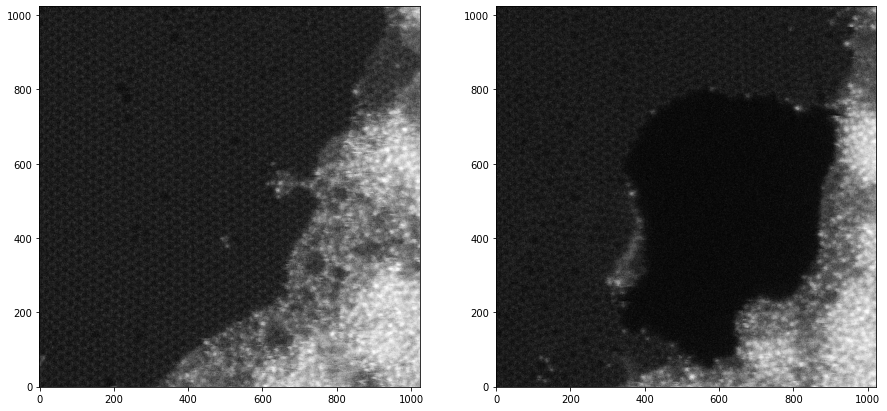

In [4]:
imgdata = np.load("Graphene_CrSi.npy")

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
ax1.imshow(imgdata[0], origin="lower", cmap='gray')
ax2.imshow(imgdata[-1], origin="lower", cmap='gray')

Remove "fly-back delay" part of the image (will need to figure out a better way to deal with this microscope distortion later):

In [5]:
imgdata = imgdata[:, 128:, 128:]

## Semantic segmentation and atom finding

Load model pre-trained on simulated data and apply it to experimental data:

In [6]:
smodel = aoi.load_model("dcnn_synthetic.tar")
decoded_imgs, coordinates = aoi.atomnet.predictor(smodel, thresh=0.33, use_gpu=True).run(imgdata)

/usr/local/lib/python3.6/dist-packages/atomai/atomnet/infer.py:163: UserWarning: The default output of predictor.decode() and predictor.run() is now ```nn_output, coords``` instead of ```nn_input, (nn_output, coords)```
  warnings.warn(warn_msg, UserWarning)


Batch 100/100
100 images were decoded in approximately 11.0328 seconds


View results for selected frames:

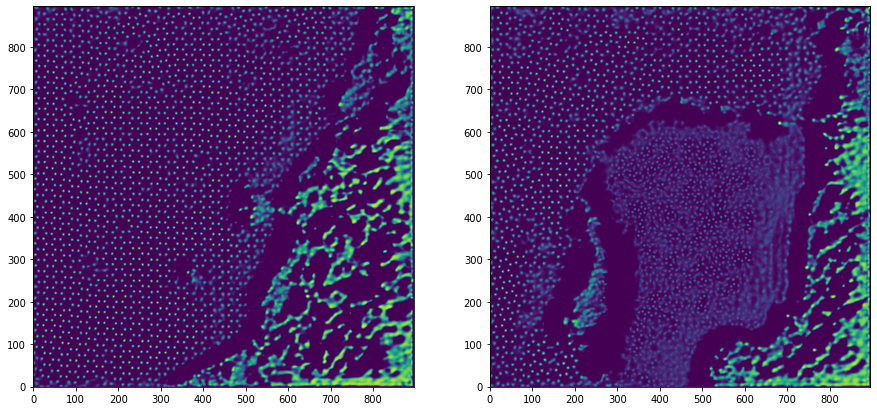

In [7]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
ax1.imshow(decoded_imgs[0,...,0], origin="lower")
ax2.imshow(decoded_imgs[99,...,0], origin="lower")

As one can see, while our model was able to find most of atoms it also identified amorphous regions as features of interest as well as mistalenly placed atoms inside the hole. This is not surprising, since neither the amorphous regions, nor the holes were the part of initial training set.

Next, we are going to do some simple cleaning of the detected atomic coordinates followed by (iterative) re-training of our DCNN model using experimental sub-images as our training set.

## Iterative re-training (adaptation to experimental data)

Let's do some cleaning. First, separate into 2 classes using Gaussian Mixture model:

/usr/local/lib/python3.6/dist-packages/atomai/atomstat/multivar.py:94: UserWarning: The crop_size argument is deprecated. Use window_size to specify size of subimages
  UserWarning)



GMM components


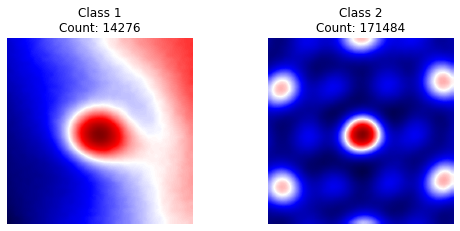

In [8]:
coordinates = aoi.atomstat.update_classes(
    coordinates, imgdata, method="gmm_local",
    n_components=2, window_size=48, coord_class=0)

Here one component clearly corresponds to the amorphous phase and another one to the lattice.

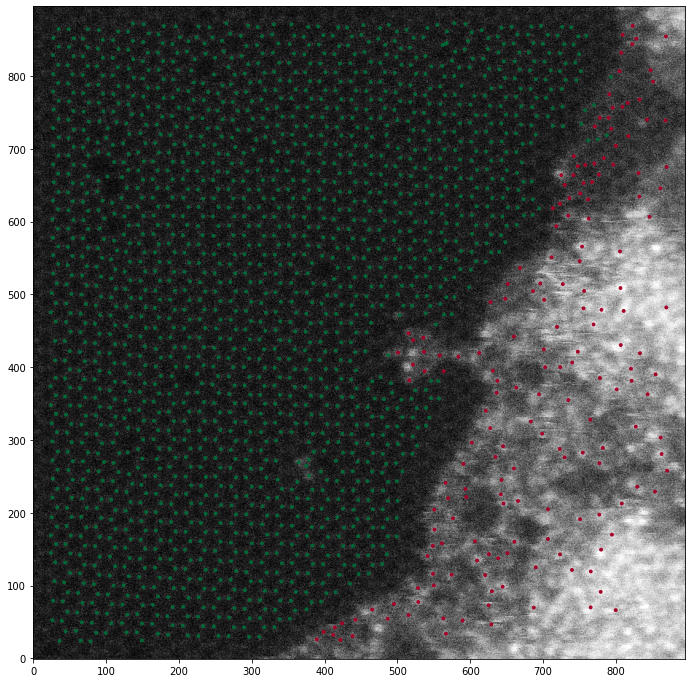

In [9]:
# Plot results
k = 0 # frame number
aoi.utils.plot_coord(imgdata[k, ...], coordinates[k], fsize=12)

Now let's filter out the coordinates corresponding to the amorphous regions:

In [10]:
coordinates_filtered = {}
for k, c in coordinates.items():
    coordinates_filtered[k] = c[c[:, -1] == 2]

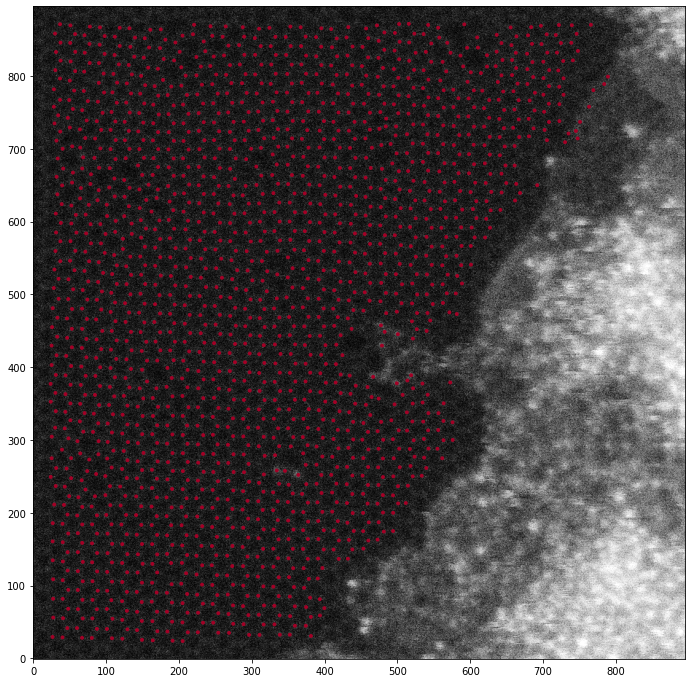

In [11]:
# Plot results
k = 5 # frame number
aoi.utils.plot_coord(imgdata[k, ...], coordinates_filtered[k], fsize=12)

### Iterative training 00

Now let's train a more narrowly-focused NN using the previous NN as a baseline. First we need to create a new training set. this time from the experimental data. Here we will use the same idea as in our [earlier work](https://www.nature.com/articles/s41524-019-0152-9) that for the movies of atomic transformations it is sufficient to train NN only on the first several frames where the positions are well defined (low degree of disorder) and we can easily label them.

Create ground truth for iterative training:

In [12]:
masks = np.zeros((6, *imgdata.shape[1:]))
for i in range(6):
    masks[i] = aoi.utils.create_lattice_mask(imgdata[i], coordinates_filtered[i][:, :-1])

In [13]:
X_train, y_train = aoi.utils.extract_patches(imgdata[:6], masks, patch_size=224, num_patches=500)
print(X_train.shape, y_train.shape)

(3000, 224, 224) (3000, 224, 224)


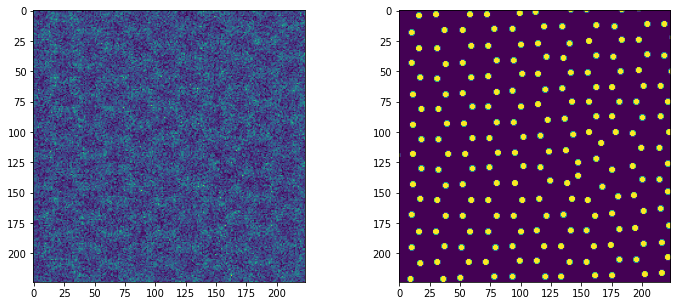

In [14]:
k = 700
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(X_train[k])
ax2.imshow(y_train[k])

Train an ensemble of models from the same baseline and use averaged weights:

In [ ]:
use_pretrained = False

if use_pretrained:
    !gdown https://drive.google.com/uc?id=1zR6uzDa5Ohbudv2T-x6r9URHasPj39tZ
    smodel00, _ = aoi.load_ensemble("Graphene-elit00_ensemble.tar")

else:
    etrainer = aoi.atomnet.ensemble_trainer(
        X_train, y_train, model='dilUnet', 
        nb_filters=32, layers=[2, 3, 3, 3],
        use_batchnorm=False, batch_size=8,
        n_models=5, strategy="from_baseline",
        gauss_noise=True, zoom=1.2, rotation=True, # on-the-fly data augmentation
        training_cycles_ensemble=1000, swa=True,
        print_loss=50, filename="Graphene-elit00") # adjust if necessary

    _, smodel00 = etrainer.train_from_baseline(smodel)

Training ensemble models:
Ensemble model 1


/usr/local/lib/python3.6/dist-packages/atomai/utils/img.py:103: UserWarning: Adding a channel dimension of 1 to training images
  UserWarning
/usr/local/lib/python3.6/dist-packages/atomai/utils/img.py:111: UserWarning: Adding a channel dimension of 1 to test images
  UserWarning
/usr/local/lib/python3.6/dist-packages/atomai/utils/img.py:128: UserWarning: Adding a channel dimension of 1 to training labels
  UserWarning
/usr/local/lib/python3.6/dist-packages/atomai/utils/img.py:136: UserWarning: Adding a channel dimension of 1 to test labels
  UserWarning


Epoch 1 ... Training loss: 0.2418 ... Test loss: 0.131 ... GPU memory usage: 4307/16130
Epoch 50 ... Training loss: 0.095 ... Test loss: 0.1026 ... GPU memory usage: 4307/16130
Epoch 100 ... Training loss: 0.0739 ... Test loss: 0.0761 ... GPU memory usage: 4307/16130
Epoch 150 ... Training loss: 0.0964 ... Test loss: 0.0773 ... GPU memory usage: 4307/16130
Epoch 200 ... Training loss: 0.1012 ... Test loss: 0.0674 ... GPU memory usage: 4307/16130
Epoch 250 ... Training loss: 0.0837 ... Test loss: 0.0422 ... GPU memory usage: 4307/16130
Epoch 300 ... Training loss: 0.0683 ... Test loss: 0.0678 ... GPU memory usage: 4307/16130
Epoch 350 ... Training loss: 0.0923 ... Test loss: 0.0922 ... GPU memory usage: 4307/16130
Epoch 400 ... Training loss: 0.0542 ... Test loss: 0.0764 ... GPU memory usage: 4307/16130
Epoch 450 ... Training loss: 0.0549 ... Test loss: 0.0868 ... GPU memory usage: 4307/16130
Epoch 500 ... Training loss: 0.0478 ... Test loss: 0.042 ... GPU memory usage: 4307/16130
Epoch

/usr/local/lib/python3.6/dist-packages/atomai/utils/img.py:103: UserWarning: Adding a channel dimension of 1 to training images
  UserWarning
/usr/local/lib/python3.6/dist-packages/atomai/utils/img.py:111: UserWarning: Adding a channel dimension of 1 to test images
  UserWarning
/usr/local/lib/python3.6/dist-packages/atomai/utils/img.py:128: UserWarning: Adding a channel dimension of 1 to training labels
  UserWarning
/usr/local/lib/python3.6/dist-packages/atomai/utils/img.py:136: UserWarning: Adding a channel dimension of 1 to test labels
  UserWarning


Epoch 1 ... Training loss: 0.2518 ... Test loss: 0.1552 ... GPU memory usage: 4327/16130
Epoch 50 ... Training loss: 0.1085 ... Test loss: 0.0885 ... GPU memory usage: 4327/16130
Epoch 100 ... Training loss: 0.1059 ... Test loss: 0.0986 ... GPU memory usage: 4327/16130
Epoch 150 ... Training loss: 0.0953 ... Test loss: 0.101 ... GPU memory usage: 4327/16130
Epoch 200 ... Training loss: 0.0606 ... Test loss: 0.0651 ... GPU memory usage: 4327/16130
Epoch 250 ... Training loss: 0.072 ... Test loss: 0.0946 ... GPU memory usage: 4327/16130
Epoch 300 ... Training loss: 0.0849 ... Test loss: 0.0824 ... GPU memory usage: 4327/16130
Epoch 350 ... Training loss: 0.092 ... Test loss: 0.0579 ... GPU memory usage: 4327/16130
Epoch 400 ... Training loss: 0.0544 ... Test loss: 0.0809 ... GPU memory usage: 4327/16130
Epoch 450 ... Training loss: 0.1039 ... Test loss: 0.085 ... GPU memory usage: 4327/16130
Epoch 500 ... Training loss: 0.0329 ... Test loss: 0.0376 ... GPU memory usage: 4327/16130
Epoch 

/usr/local/lib/python3.6/dist-packages/atomai/utils/img.py:103: UserWarning: Adding a channel dimension of 1 to training images
  UserWarning
/usr/local/lib/python3.6/dist-packages/atomai/utils/img.py:111: UserWarning: Adding a channel dimension of 1 to test images
  UserWarning
/usr/local/lib/python3.6/dist-packages/atomai/utils/img.py:128: UserWarning: Adding a channel dimension of 1 to training labels
  UserWarning
/usr/local/lib/python3.6/dist-packages/atomai/utils/img.py:136: UserWarning: Adding a channel dimension of 1 to test labels
  UserWarning


Epoch 1 ... Training loss: 0.2483 ... Test loss: 0.1003 ... GPU memory usage: 4331/16130
Epoch 50 ... Training loss: 0.083 ... Test loss: 0.0901 ... GPU memory usage: 4331/16130
Epoch 100 ... Training loss: 0.0802 ... Test loss: 0.0879 ... GPU memory usage: 4331/16130
Epoch 150 ... Training loss: 0.0835 ... Test loss: 0.0985 ... GPU memory usage: 4331/16130
Epoch 200 ... Training loss: 0.0861 ... Test loss: 0.0839 ... GPU memory usage: 4331/16130
Epoch 250 ... Training loss: 0.072 ... Test loss: 0.0584 ... GPU memory usage: 4331/16130
Epoch 300 ... Training loss: 0.0711 ... Test loss: 0.121 ... GPU memory usage: 4331/16130
Epoch 350 ... Training loss: 0.0678 ... Test loss: 0.0619 ... GPU memory usage: 4331/16130
Epoch 400 ... Training loss: 0.0832 ... Test loss: 0.0335 ... GPU memory usage: 4331/16130
Epoch 450 ... Training loss: 0.068 ... Test loss: 0.0676 ... GPU memory usage: 4331/16130
Epoch 500 ... Training loss: 0.04 ... Test loss: 0.0641 ... GPU memory usage: 4331/16130
Epoch 55

/usr/local/lib/python3.6/dist-packages/atomai/utils/img.py:103: UserWarning: Adding a channel dimension of 1 to training images
  UserWarning
/usr/local/lib/python3.6/dist-packages/atomai/utils/img.py:111: UserWarning: Adding a channel dimension of 1 to test images
  UserWarning
/usr/local/lib/python3.6/dist-packages/atomai/utils/img.py:128: UserWarning: Adding a channel dimension of 1 to training labels
  UserWarning
/usr/local/lib/python3.6/dist-packages/atomai/utils/img.py:136: UserWarning: Adding a channel dimension of 1 to test labels
  UserWarning


Epoch 1 ... Training loss: 0.2406 ... Test loss: 1.6001 ... GPU memory usage: 4337/16130
Epoch 50 ... Training loss: 0.1142 ... Test loss: 0.0758 ... GPU memory usage: 4337/16130
Epoch 100 ... Training loss: 0.0548 ... Test loss: 0.0781 ... GPU memory usage: 4337/16130
Epoch 150 ... Training loss: 0.0784 ... Test loss: 0.0922 ... GPU memory usage: 4337/16130
Epoch 200 ... Training loss: 0.0727 ... Test loss: 0.0886 ... GPU memory usage: 4337/16130
Epoch 250 ... Training loss: 0.0405 ... Test loss: 0.0638 ... GPU memory usage: 4337/16130
Epoch 300 ... Training loss: 0.0842 ... Test loss: 0.0851 ... GPU memory usage: 4337/16130
Epoch 350 ... Training loss: 0.0787 ... Test loss: 0.1029 ... GPU memory usage: 4337/16130
Epoch 400 ... Training loss: 0.0578 ... Test loss: 0.0659 ... GPU memory usage: 4337/16130
Epoch 450 ... Training loss: 0.0648 ... Test loss: 0.1037 ... GPU memory usage: 4337/16130
Epoch 500 ... Training loss: 0.0699 ... Test loss: 0.0688 ... GPU memory usage: 4337/16130
Ep

/usr/local/lib/python3.6/dist-packages/atomai/utils/img.py:103: UserWarning: Adding a channel dimension of 1 to training images
  UserWarning
/usr/local/lib/python3.6/dist-packages/atomai/utils/img.py:111: UserWarning: Adding a channel dimension of 1 to test images
  UserWarning
/usr/local/lib/python3.6/dist-packages/atomai/utils/img.py:128: UserWarning: Adding a channel dimension of 1 to training labels
  UserWarning
/usr/local/lib/python3.6/dist-packages/atomai/utils/img.py:136: UserWarning: Adding a channel dimension of 1 to test labels
  UserWarning


Epoch 1 ... Training loss: 0.2238 ... Test loss: 0.2168 ... GPU memory usage: 4353/16130
Epoch 50 ... Training loss: 0.0855 ... Test loss: 0.1239 ... GPU memory usage: 4353/16130
Epoch 100 ... Training loss: 0.0963 ... Test loss: 0.078 ... GPU memory usage: 4353/16130
Epoch 150 ... Training loss: 0.0745 ... Test loss: 0.0636 ... GPU memory usage: 4353/16130
Epoch 200 ... Training loss: 0.1176 ... Test loss: 0.0573 ... GPU memory usage: 4353/16130
Epoch 250 ... Training loss: 0.0516 ... Test loss: 0.0931 ... GPU memory usage: 4353/16130
Epoch 300 ... Training loss: 0.0644 ... Test loss: 0.096 ... GPU memory usage: 4353/16130
Epoch 350 ... Training loss: 0.1058 ... Test loss: 0.052 ... GPU memory usage: 4353/16130
Epoch 400 ... Training loss: 0.0914 ... Test loss: 0.0598 ... GPU memory usage: 4353/16130
Epoch 450 ... Training loss: 0.0844 ... Test loss: 0.0815 ... GPU memory usage: 4353/16130
Epoch 500 ... Training loss: 0.0671 ... Test loss: 0.0598 ... GPU memory usage: 4353/16130
Epoch

Apply the newly trained model to the same experimental data:

In [17]:
decoded_imgs, coordinates = aoi.atomnet.predictor(smodel00, thresh=0.5, use_gpu=True).run(imgdata)

/usr/local/lib/python3.6/dist-packages/atomai/atomnet/infer.py:163: UserWarning: The default output of predictor.decode() and predictor.run() is now ```nn_output, coords``` instead of ```nn_input, (nn_output, coords)```
  warnings.warn(warn_msg, UserWarning)


Batch 100/100
100 images were decoded in approximately 10.3754 seconds


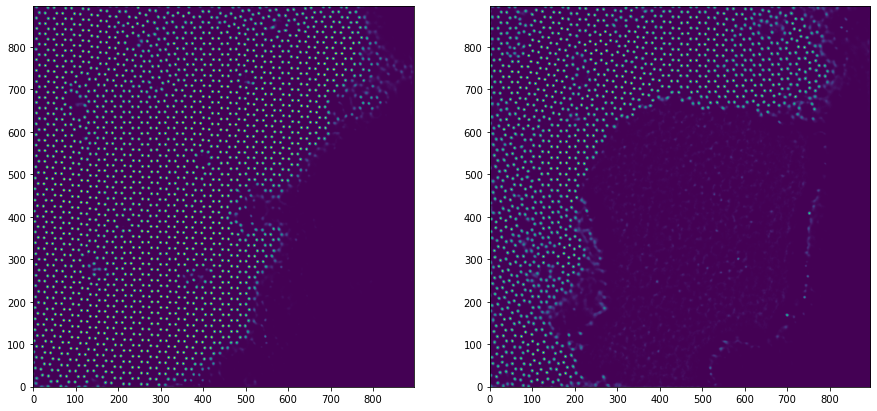

In [18]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
ax1.imshow(decoded_imgs[0,...,0], origin="lower")
ax2.imshow(decoded_imgs[99,...,0], origin="lower")

Looks much better!

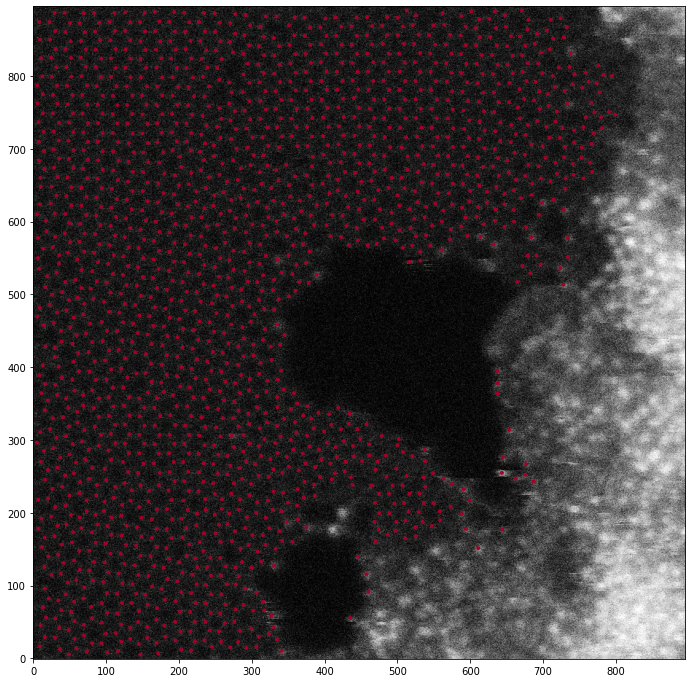

In [19]:
# Plot results
k = 63 # frame number
aoi.utils.plot_coord(imgdata[k, ...], coordinates[k], fsize=12)

Now let's do some extra cleaning using grahs. We will find disconnected graphs and use them to filter out the remaining "atoms" at amorphous regions and inside of holes:

(Note: currently the process is slow. The (much) faster version will be available in the next AtomAI's release. Once released, we will updated this notebook)

In [ ]:
map_dict = {
    0: "C",
    1: "Si", # right now we don't have it, this is just an example
}

# This may take some time (20-30 min). We now have a much faster version of this method
# which will be available in the next release of AtomAI.
coordinates_filtered = aoi.utils.filter_subgraphs(coordinates, 19, map_dict) 

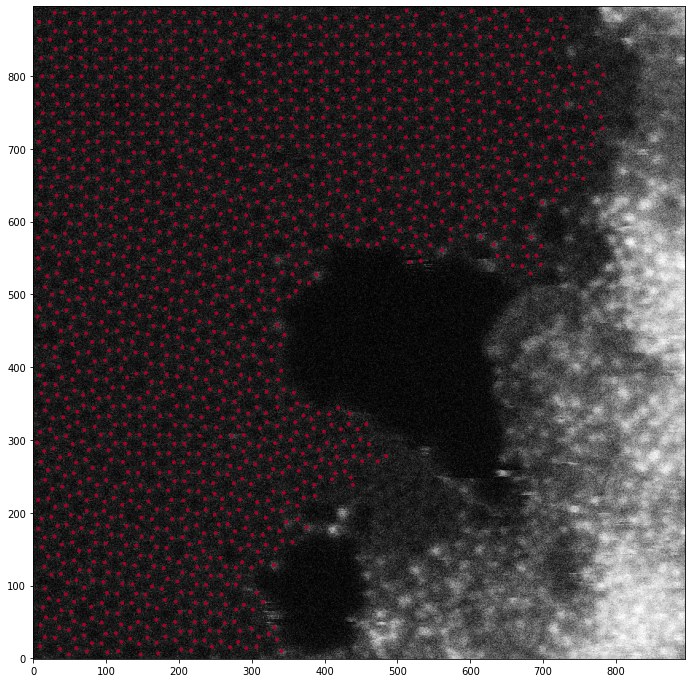

In [ ]:
k = 63
aoi.utils.plot_coord(imgdata[k], coordinates_filtered[k], fsize=12)

### Iterative training 01

Create training data (now using random crops from all the frames):

In [21]:
masks = np.zeros_like(imgdata)
for i in range(len(imgdata)):
    masks[i] = aoi.utils.create_lattice_mask(imgdata[i], coordinates_filtered[i][:, :-1])

In [22]:
X_train, y_train = aoi.utils.extract_patches(imgdata, masks, patch_size=224, num_patches=50)
print(X_train.shape, y_train.shape)

(5000, 224, 224) (5000, 224, 224)


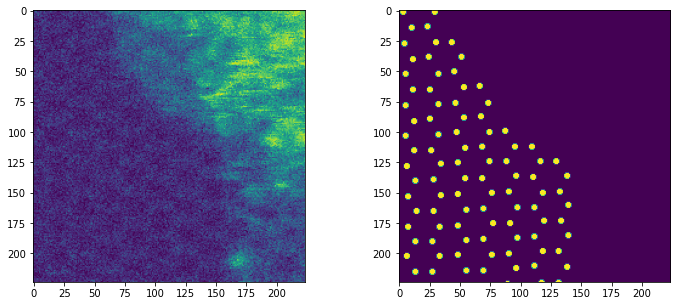

In [23]:
k = 35
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(X_train[k])
ax2.imshow(y_train[k])

Train a single model from the baseline:

In [ ]:
use_pretrained = False

if use_pretrained:
    !gdown https://drive.google.com/uc?id=1q8hM3P_M8TpQsHSVOqxhm3x0YDqdaph6
    smodel01, _ = aoi.load_ensemble("Graphene-elit01_ensemble.tar")

else:
    etrainer = aoi.atomnet.ensemble_trainer(
        X_train, y_train, model='dilUnet', 
        nb_filters=32, layers=[2, 3, 3, 3],
        use_batchnorm=False, batch_size=32,
        n_models=1, strategy="from_baseline", full_epoch=True,
        training_cycles_ensemble=20, swa=True,
        print_loss=1, filename="Graphene-elit01")

    _, smodel01 = etrainer.train_from_baseline(smodel00)

Training ensemble models:
Ensemble model 1


/usr/local/lib/python3.6/dist-packages/atomai/utils/img.py:103: UserWarning: Adding a channel dimension of 1 to training images
  UserWarning
/usr/local/lib/python3.6/dist-packages/atomai/utils/img.py:111: UserWarning: Adding a channel dimension of 1 to test images
  UserWarning
/usr/local/lib/python3.6/dist-packages/atomai/utils/img.py:128: UserWarning: Adding a channel dimension of 1 to training labels
  UserWarning
/usr/local/lib/python3.6/dist-packages/atomai/utils/img.py:136: UserWarning: Adding a channel dimension of 1 to test labels
  UserWarning


Epoch 1 ... Training loss: 0.031 ... Test loss: 0.0267 ... GPU memory usage: 10029/16130
Epoch 2 ... Training loss: 0.0251 ... Test loss: 0.025 ... GPU memory usage: 10029/16130
Epoch 3 ... Training loss: 0.0225 ... Test loss: 0.0251 ... GPU memory usage: 10029/16130
Epoch 4 ... Training loss: 0.0198 ... Test loss: 0.0226 ... GPU memory usage: 10029/16130
Epoch 5 ... Training loss: 0.0184 ... Test loss: 0.0241 ... GPU memory usage: 10029/16130
Epoch 6 ... Training loss: 0.0161 ... Test loss: 0.0228 ... GPU memory usage: 10029/16130
Epoch 7 ... Training loss: 0.0149 ... Test loss: 0.0248 ... GPU memory usage: 10029/16130
Epoch 8 ... Training loss: 0.0131 ... Test loss: 0.0247 ... GPU memory usage: 10029/16130
Epoch 9 ... Training loss: 0.0117 ... Test loss: 0.0247 ... GPU memory usage: 10029/16130
Epoch 10 ... Training loss: 0.011 ... Test loss: 0.0265 ... GPU memory usage: 10029/16130
Epoch 11 ... Training loss: 0.01 ... Test loss: 0.0273 ... GPU memory usage: 10029/16130
Epoch 12 ... 

Apply to experimental data:

In [27]:
decoded_imgs, coordinates = aoi.atomnet.predictor(smodel01, thresh=0.5, use_gpu=True).run(imgdata)

/usr/local/lib/python3.6/dist-packages/atomai/atomnet/infer.py:163: UserWarning: The default output of predictor.decode() and predictor.run() is now ```nn_output, coords``` instead of ```nn_input, (nn_output, coords)```
  warnings.warn(warn_msg, UserWarning)


Batch 100/100
100 images were decoded in approximately 10.3202 seconds


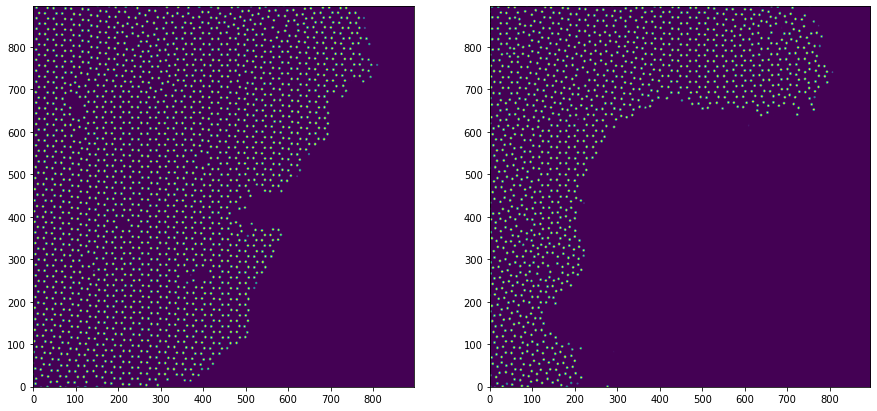

In [28]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
ax1.imshow(decoded_imgs[0,...,0], origin="lower")
ax2.imshow(decoded_imgs[-1,...,0], origin="lower")

Now we use this model to creat a training set for variational autoencoder.

First, we will use a simple thresholding to separate lattice atoms from impurity atoms:

In [29]:
norm = lambda x: (x - x.min()) / x.ptp()
imgdata_ = [norm(im)[None] for im in imgdata]
imgdata = np.concatenate(imgdata_, axis=0)

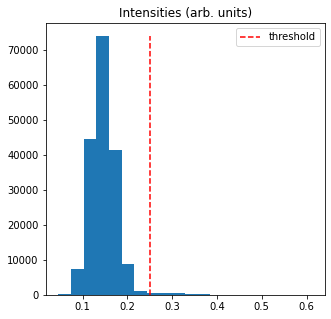

In [30]:
coordinates_filtered_updated = aoi.atomstat.update_classes(
    coordinates, imgdata, method='threshold', thresh=.25)

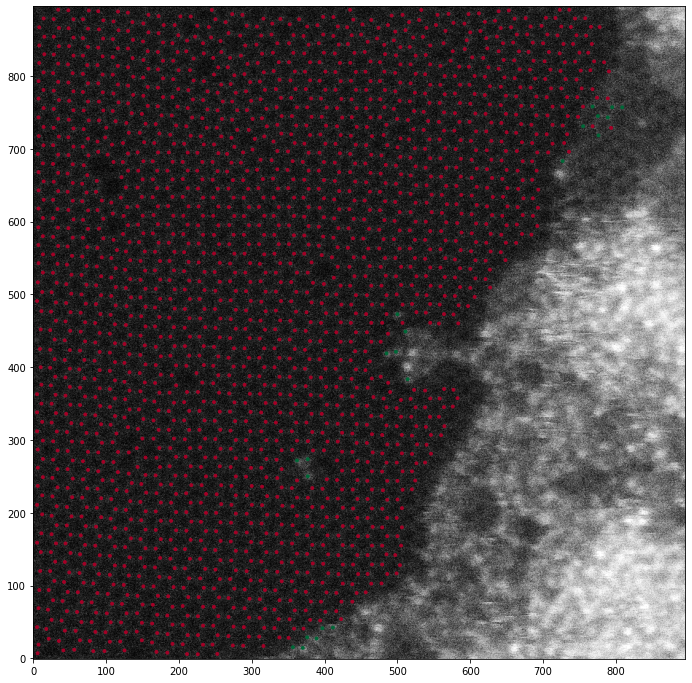

In [31]:
# Plot results
k = 0 # frame number
aoi.utils.plot_coord(imgdata[k, ...], coordinates_filtered_updated[k], fsize=12)

Save the decoded images, updated coordiantes and the experimental data:

In [ ]:
np.savez("/content/drive/My Drive/research/ChemDisc/Gdata_for_VAE0.npz",
         coordinates=coordinates_filtered_updated,
         decoded_imgs=decoded_imgs,
         imgdata=imgdata)

# Watermarks

In [ ]:
!pip install watermark > /dev/null

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w

atomai 0.5.2
numpy  1.18.5
last updated: Mon Oct 19 2020 

CPython 3.6.9
IPython 5.5.0
watermark 2.0.2
